### IMPORTING NECESSARY LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import copy
import statistics
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

### DEFINING NECESSARY FUNCTIONS

#### READING SYNTHETIC BIOMARKERS DATA

In [3]:
def synthetic_dataset(biomarkers = [i for i in range(1,11)]):
    data = pd.read_csv('Synthetic Data.csv')
    biomarkers = np.array(biomarkers)-1
    data = data.iloc[:,list(biomarkers) + [-2,-1]]
    return data

#### HISTOGRAM OF BIOMARKER VALUES IN AD VS CN SUBPOPULATION

In [4]:
def biomarkers_distribution(data):
    biomarkers = data.shape[1]-2
    biomarker_name = data.columns[:biomarkers]
    rows = biomarkers//2 + biomarkers%2
    columns = 2
    fig,ax = plt.subplots(rows,columns,figsize=(10,rows*3))
    for biomarker_number in range(len(biomarker_name)):
        ad_data = data[data['Condition Name']=='AD'].iloc[:,biomarker_number]
        cn_data = data[data['Condition Name']=='CN'].iloc[:,biomarker_number]
        ax[biomarker_number//2,biomarker_number%2].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','skyblue'])
        ax[biomarker_number//2,biomarker_number%2].set_title(biomarker_name[biomarker_number])
    if biomarkers%2==1:
        ax[rows-1,columns-1].set_axis_off()
    ax[0,0].legend()
    fig.tight_layout()

#### FITTING MIXTURE MODELS

In [5]:
def EM(X,number_of_clusters=2,number_of_iterations = 500):

    iteration_nums = []
    likelihood = []
    
    means = np.linspace(min(X),max(X),number_of_clusters)
    stds = np.ones(number_of_clusters)
    weights = np.full(number_of_clusters,1.0/number_of_clusters)

    for iteration in range(1,number_of_iterations):
        contribution = []
        
        for i in range(number_of_clusters):
            contribution.append(weights[i]*norm.pdf(X,means[i],stds[i]))
    
        contribution = np.array(contribution)/np.sum(contribution,axis=0)
        
        for i in range(number_of_clusters):
            weights[i] = np.mean(contribution[i])
            means[i] = np.sum(contribution[i]*X)/np.sum(contribution[i])
            stds[i] = np.sqrt(np.sum(contribution[i]*(X - means[i])**2)/np.sum(contribution[i]))

        log_likelihood = np.sum(np.log(np.sum([weights[i]*norm.pdf(X,means[i],stds[i]) for i in range(2)],axis=0)))
        
        if iteration>10 and np.array_equal(np.full(10,np.round(log_likelihood,2)),np.round(likelihood[-10:],2)):
            break
        else:
            likelihood.append(log_likelihood)
            iteration_nums.append(iteration)

    return means,stds,weights

#### DENSITY ESTIMATION USING EM

In [6]:
def density_estimation(data):
    biomarkers = data.shape[1]-2
    biomarker_name = data.columns[:biomarkers]
    number_of_biomarkers = len(biomarker_name)
    
    rows = biomarkers//2 + biomarkers%2
    columns = 2
    fig,ax = plt.subplots(rows,columns,figsize=(10,rows*3))
    gmm_parameters = {}

    for biomarker_number in range(number_of_biomarkers):
        
        biomarker_data = data.iloc[:,biomarker_number]
        means,stds,weights = EM(biomarker_data)
    
        # Original Data with Labels
        ad_data = data[data['Condition Name']=='AD'].iloc[:,biomarker_number]
        cn_data = data[data['Condition Name']=='CN'].iloc[:,biomarker_number]
        x_index,y_index = biomarker_number//2,biomarker_number%2
    
        ax[x_index,y_index].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','skyblue'],density=True,bins=10)
        gmm_parameters[biomarker_name[biomarker_number]] = [weights,means,stds]
    
        # Fitted GMM model
        X_sorted = np.sort(biomarker_data)
        cn_density_estimation = weights[0]*norm.pdf(X_sorted, means[0],stds[0])
        ad_density_estimation = weights[1]*norm.pdf(X_sorted, means[1],stds[1])
        density_estimation = (cn_density_estimation + ad_density_estimation)
        ax[x_index,y_index].plot(X_sorted,cn_density_estimation*2, color='skyblue', linewidth=2)
        ax[x_index,y_index].plot(X_sorted,ad_density_estimation*2, color='orange', linewidth=2)
        ax[x_index,y_index].set_title(biomarker_name[biomarker_number])

    if biomarkers%2==1:
        ax[rows-1,columns-1].set_axis_off()

    ax[0,0].legend()
    fig.tight_layout()
    return gmm_parameters

#### DEFINING LIKELIHOOD FUNCTION

In [7]:
def patient_likelihood_at_K(individual_data,event_sequence,K,gmm_parameters):

    ''' If a patient is at the position k in the progression model,
        where events upto k have occured and rest have not'''

    means =  [gmm_parameters[event_sequence[event]][1][1] for event in range(K+1)] + \
             [gmm_parameters[event_sequence[event]][1][0] for event in range(K+1,len(event_sequence))]

    stds =   [gmm_parameters[event_sequence[event]][2][1] for event in range(K+1)] + \
             [gmm_parameters[event_sequence[event]][2][0] for event in range(K+1,len(event_sequence))]
    
    likelihood = norm.pdf(individual_data,means,stds)
    return np.prod(likelihood)
    
def patient_likelihood(individual_data,event_sequence,gmm_parameters):

    ''' Integrating out the hidden variable K '''
    individual_data_likelihood=0
    uniform_prior = 1.0/len(event_sequence)
    for event in range(len(event_sequence)):
        likelihood_at_k = patient_likelihood_at_K(individual_data,event_sequence,event,gmm_parameters)
        individual_data_likelihood+=likelihood_at_k
    return np.log(uniform_prior*individual_data_likelihood)

def data_likelihood(patients_data,biomarker_names,event_sequence,gmm_parameters):
    
    patients_data = np.reshape(patients_data,(-1, len(biomarker_names)))
    rows = patients_data.shape[0]
    columns = patients_data.shape[1]
    data_likelihood = 0
    
    for patient_number in range(rows):
        individual_data = patients_data[patient_number]
        data_likelihood+=patient_likelihood(individual_data,event_sequence,gmm_parameters)
    
    return data_likelihood

#### GREEDY ASCENT ALGORITHM

In [8]:
def greedy_ascent(dataframe,biomarker_names,gmm_parameters,iterations=100,n_initial=5):
    
    sequences = []
    likelihoods = []
    
    for n in range(n_initial):
        likelihood = []
        sequence = copy.deepcopy(biomarker_names)
        random.shuffle(sequence)
        sorted_data = dataframe[sequence]
        data = sorted_data.to_numpy()
        ml_likelihood = data_likelihood(data,biomarker_names,sequence,gmm_parameters)
        for iteration_number in tqdm(range(iterations)):
            new_sequence = copy.deepcopy(sequence)
            index_1, index_2 = random.sample(range(len(sequence)), 2)
            new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1]
            sorted_data = dataframe[new_sequence]
            data = sorted_data.to_numpy()
            new_likelihood = data_likelihood(data,biomarker_names,new_sequence,gmm_parameters)
            if new_likelihood>ml_likelihood:
                ml_likelihood=new_likelihood
                sequence=new_sequence
            likelihood.append(ml_likelihood)
        sequences.append(sequence)
        likelihoods.append(likelihood)

    transposed = np.array(sequences).T
    most_probable_sequence = [str(statistics.mode(x)) for x in transposed]
    
    for values in likelihoods:
        plt.plot(values)
    plt.show()
    
    return most_probable_sequence

#### MARKOV CHAIN MONTE CARLO ALGORITHM

In [9]:
def mcmc(dataframe,biomarker_names,gmm_parameters,ml_sequence,iterations=100):
    current_sequence = copy.deepcopy(ml_sequence)
    sorted_data = dataframe[current_sequence]
    data = sorted_data.to_numpy()
    current_likelihood = data_likelihood(data,biomarker_names,current_sequence,gmm_parameters)
    final_sequences = []
    
    for iteration_number in tqdm(range(iterations)):
        new_sequence = copy.deepcopy(current_sequence)
        index_1, index_2 = random.sample(range(len(new_sequence)), 2)
        new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1]
        sorted_data = dataframe[new_sequence]
        data = sorted_data.to_numpy()
        new_likelihood = data_likelihood(data,biomarker_names,new_sequence,gmm_parameters)
        check = np.exp(new_likelihood - current_likelihood)
        if random.random()<=check:
            current_sequence=new_sequence
            current_likelihood=new_likelihood
        final_sequences.append(current_sequence)
        
    return final_sequences

#### POSITIONAL VARIANCE DIAGRAM

In [10]:
def positional_variance_diagram(data,sequences):
    events = [number for number in range(1,data.shape[1]+1)]
    transposed = np.array(sequences).T
    most_probable_sequence = [str(statistics.mode(x)) for x in transposed]
    confusion_matrix_values = np.zeros((len(events),len(events)))
    for column in range(len(events)):
        for row in range(len(events)):
            biomarker = most_probable_sequence[row]
            count = np.sum(transposed[column]==biomarker)
            confusion_matrix_values[row][column]=count
    
    fig, ax = plt.subplots()
    
    ax.matshow(confusion_matrix_values, cmap=plt.cm.Purples)
    ticks_position = np.array(events)-1
    ax.set_xticks(ticks_position,events)
    ax.set_yticks(ticks_position,most_probable_sequence) 
    ax.set_ylabel('Biomarker Name', fontsize=15)
    ax.set_xlabel('Event Order', fontsize=15)

### IMPLEMENTATION ON SYNTHETIC DATASET

In [15]:
df = synthetic_dataset([1,2,3,4,5])
df.head()

,BM1,BM2,BM3,BM4,BM5,Condition Name,Condition
0,-0.692,-0.190,1.217,-1.142,0.082,CN,0
1,0.199,-0.238,-0.156,0.627,0.288,CN,0
2,-0.668,1.080,1.161,0.399,0.070,AD,1
3,1.091,-0.796,0.012,0.705,0.052,CN,0
4,1.195,2.981,4.020,2.057,3.439,AD,1


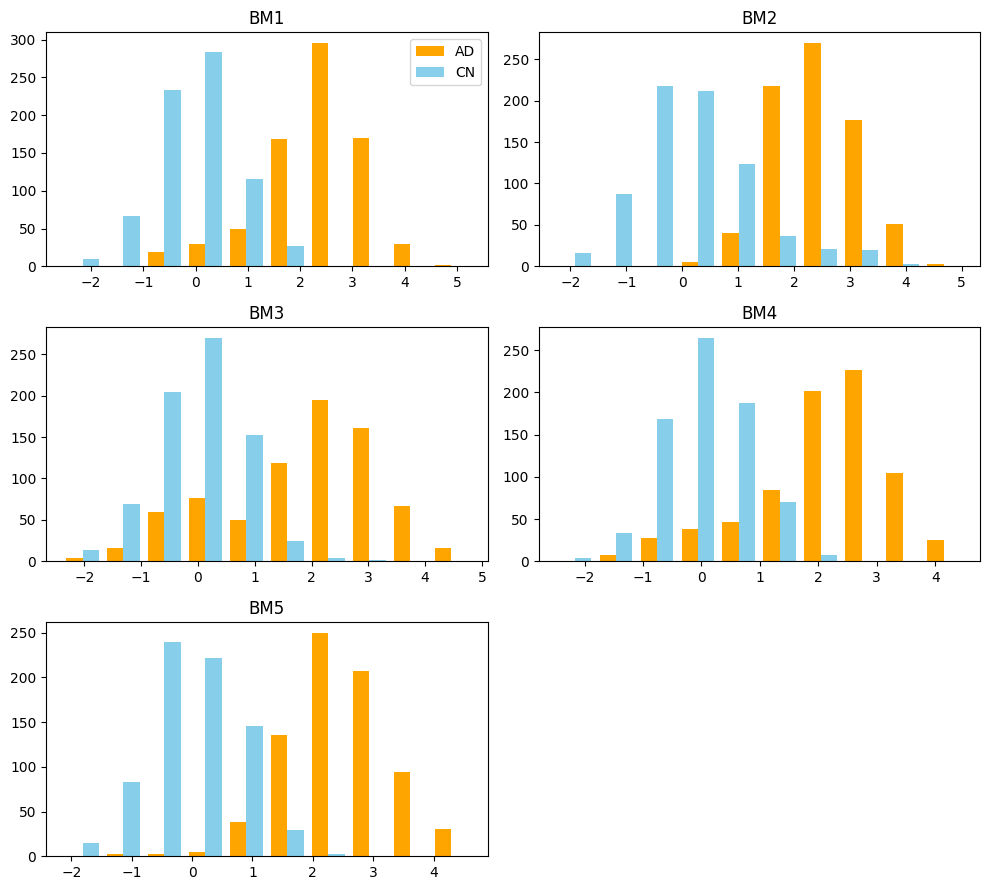

In [16]:
biomarkers_distribution(df)

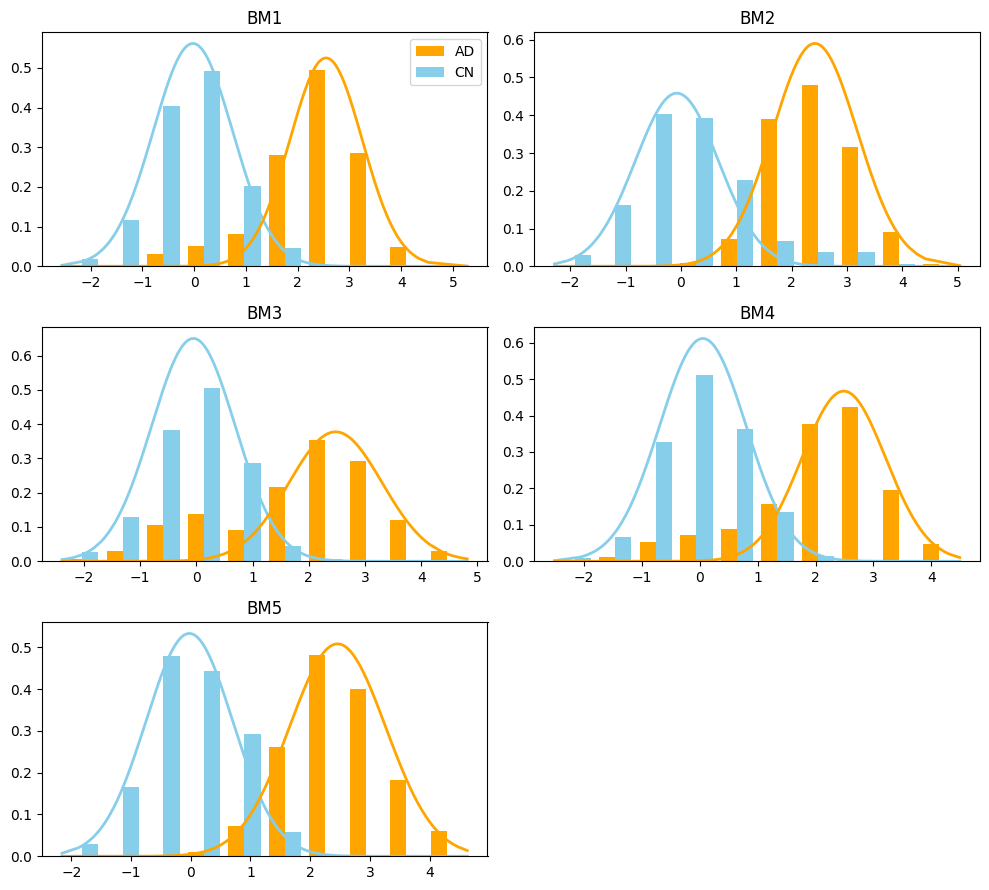

In [17]:
gmm_parameters = density_estimation(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


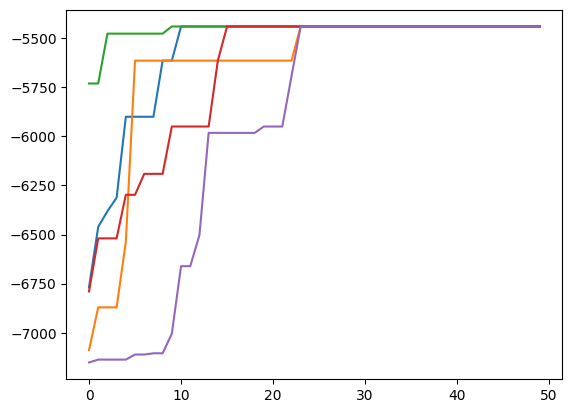

In [19]:
ad_data = df[df['Condition']==1].iloc[:,:-2].reset_index(drop=True)
biomarker_names = list(ad_data.columns)
ml_sequence = greedy_ascent(ad_data,biomarker_names,gmm_parameters,50,5)

In [20]:
print(ml_sequence)

['BM2', 'BM5', 'BM1', 'BM4', 'BM3']


In [21]:
mcmc_samples = mcmc(ad_data,biomarker_names,gmm_parameters,ml_sequence,iterations=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:00<00:00,  1.39it/s]


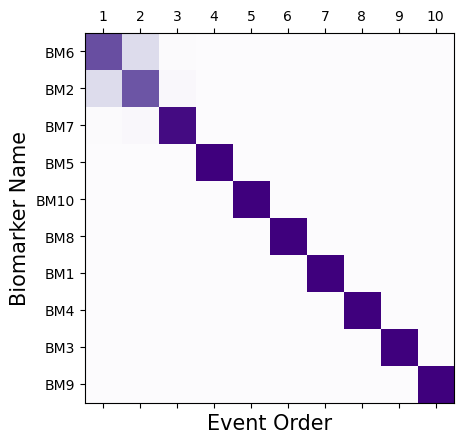

In [16]:
positional_variance_diagram(ad_data,mcmc_samples)

In [18]:
ad_data = df[df['Condition']==1].iloc[:,:-2].reset_index(drop=True)
ad_data.head()

,BM1,BM2,BM3,BM4,BM5,BM6
0,-0.668,1.080,1.161,0.399,0.070,1.554
1,1.195,2.981,4.020,2.057,3.439,2.455
2,0.701,1.542,0.305,1.554,0.827,1.452
3,-0.310,3.452,-1.073,0.576,0.953,3.680
4,3.574,2.642,2.414,1.522,1.589,2.122


In [19]:
biomarker_names = list(ad_data.columns)
X = ad_data.to_numpy()

print(data_likelihood(X,biomarker_names,ml_sequence,gmm_parameters),'\n')
print(data_likelihood(X,biomarker_names,['BM6','BM2','BM5','BM1','BM4','BM3'],gmm_parameters),'\n')

-7077.7814730054 

-7082.599009572826 



In [23]:
ml_sequence

['BM6', 'BM5', 'BM2', 'BM1', 'BM4', 'BM3']

In [25]:
X = df[ml_sequence]
X

,BM6,BM5,BM2,BM1,BM4,BM3
0,-0.356,0.082,-0.190,-0.692,-1.142,1.217
1,0.554,0.288,-0.238,0.199,0.627,-0.156
2,1.554,0.070,1.080,-0.668,0.399,1.161
3,3.934,0.052,-0.796,1.091,0.705,0.012
4,2.455,3.439,2.981,1.195,2.057,4.020
...,...,...,...,...,...,...
1495,2.615,2.657,2.573,2.490,-0.816,0.484
1496,3.757,0.180,0.373,-1.167,-0.379,0.807
1497,1.728,2.160,2.733,3.131,3.447,1.935
1498,3.376,1.538,2.735,3.113,0.810,-1.269


In [138]:
def patient_likelihood_at_K(individual_data,event_sequence,K,gmm_parameters):

    ''' If a patient is at the position k in the progression model,
        where events upto k have occured and rest have not'''

    means =  [gmm_parameters[event_sequence[event]][1][1] for event in range(K+1)] + \
             [gmm_parameters[event_sequence[event]][1][0] for event in range(K+1,len(event_sequence))]

    stds =   [gmm_parameters[event_sequence[event]][2][1] for event in range(K+1)] + \
             [gmm_parameters[event_sequence[event]][2][0] for event in range(K+1,len(event_sequence))]
    
    likelihood = norm.pdf(individual_data,means,stds)
    return np.prod(likelihood)
    
def patient_likelihood(individual_data,event_sequence,gmm_parameters):

    ''' Integrating out the hidden variable K '''
    individual_data_likelihood=0
    uniform_prior = 1.0/len(event_sequence)
    for event in range(len(event_sequence)):
        likelihood_at_k = patient_likelihood_at_K(individual_data,event_sequence,event,gmm_parameters)
        individual_data_likelihood+=likelihood_at_k
    return np.log(uniform_prior*individual_data_likelihood)

def data_likelihood(patients_data,biomarker_names,event_sequence,gmm_parameters):
    
    patients_data = np.reshape(patients_data,(-1, len(biomarker_names)))
    rows = patients_data.shape[0]
    columns = patients_data.shape[1]
    data_likelihood = 0
    
    for patient_number in range(rows):
        individual_data = patients_data[patient_number]
        data_likelihood+=patient_likelihood(individual_data,event_sequence,gmm_parameters)
    
    return data_likelihood

In [137]:
ad_data = df[df['Condition']==1].iloc[:,:-2].reset_index(drop=True)
biomarker_names = list(ad_data.columns)
ad_data.head()

,BM1,BM2,BM3,BM4,BM5,BM6
0,-0.668,1.080,1.161,0.399,0.070,1.554
1,1.195,2.981,4.020,2.057,3.439,2.455
2,0.701,1.542,0.305,1.554,0.827,1.452
3,-0.310,3.452,-1.073,0.576,0.953,3.680
4,3.574,2.642,2.414,1.522,1.589,2.122


In [135]:
sequence = ['BM6', 'BM5', 'BM2', 'BM1', 'BM4', 'BM3']
sorted_data = ad_data[sequence]
X = sorted_data.to_numpy()
data_likelihood(X[0],biomarker_names,sequence,gmm_parameters)

0.0005534790860216704
6.355713401094198e-06
4.327376080265874e-06
1.7490605349361795e-10
3.2076713943498114e-12
3.1028898727663682e-12


np.float64(-9.271927950595694)

In [ ]:
sequence_1 = ['BM6', 'BM5', 'BM2', 'BM1', 'BM4', 'BM3']
sequence_2 = ['BM6', 'BM2', 'BM5', 'BM1', 'BM4', 'BM3']

sorted_data = ad_data[sequence_1]
X = sorted_data.to_numpy()
print(data_likelihood(X,biomarker_names,sequence_1,gmm_parameters))

sorted_data = ad_data[sequence_2]
X = sorted_data.to_numpy()
print(data_likelihood(X,biomarker_names,sequence_2,gmm_parameters))